## 2. Ensemble-based models to predict tissue
We are interested in predicting the tissue of origin using the latent spaces generated before.

Using samples projected into the different latent spaces, use at least two ensemble approaches to predict their tissue of origin:
One approach must use a learner/estimator that tends to overfit data.
Another approach must use a weak learner that slightly outperforms a random estimator.
Use a model evaluation strategy that allows you to play with different hyperparameters to select the best model, assess whether the models are good predictors across all tissues (take a look at the classification_reportLinks to an external site. function in sklearn) and whether they generalize well on unseen data.

### Load data and packages

In [2]:
# import packages
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
import umap 
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



In [3]:
# Set up cross-validation with a fixed random_state
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [4]:
# import data from 01_preprocessing jupyter notebook
GTEx_data = pd.read_pickle("../GTEx_data_input.pkl")
GTEx_labels = pd.read_pickle("../GTEx_labels.pkl")

In [5]:
# set up PCA of GTEx data based on best parameters from 01_dimension_reduction
# reduce GTEx data to a PCA of 40 dimensions, considered best
pca = PCA(n_components=40)
pca_fit = pca.fit(GTEx_data)
pca_data = pca_fit.transform(GTEx_data)

In [6]:
pca_data.shape

(12385, 40)

In [7]:
# set up UMAP of GTEx data based on best parameters from 01_dimension_reduction
# reduce data with UMAP, set seed because stochastic
umap = umap.UMAP(random_state=42, n_components=200, min_dist=0.1, n_neighbors=50)
umap_fit = umap.fit(GTEx_data) 
umap_data = umap_fit.transform(GTEx_data) 

/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
# set up labels in numeric format
le = LabelEncoder()
le.fit(GTEx_labels)
y_lan = le.transform(GTEx_labels)

### Validation Set Generation

Prior to parameter tuning, we will remove 20% of the data from GTEx_data to be used to evaluate the resulting tuned models. 
We'll generate the same unseen dataset for both latent spaces. Setting a seed should be enough (according to [stackexchange](https://stackoverflow.com/questions/43095076/scikit-learn-train-test-split-can-i-ensure-same-splits-on-different-datasets))

In [9]:
# train datasets will be used in parameter tuning which will be done with cross-folds validation. 
# test datasets will be used on the final tuned model to evaluate how generalizable it is.

# both pca and umap use the same seed, so will have the same split of samples 

PCA_train, PCA_test, UMAP_train, UMAP_test, y_train, y_test = train_test_split(
    pca_data, umap_data, y_lan, test_size=0.20, random_state=42)


In [10]:
print(f"Training sample size: {PCA_train.shape[0]}")
print(f"Test sample size: {PCA_test.shape[0]}")
print(f"Number of features of PCA: {PCA_train.shape[1]}")
print(f"Number of features of UMAP: {UMAP_train.shape[1]}")


Training sample size: 9908
Test sample size: 2477
Number of features of PCA: 40
Number of features of UMAP: 200


### Ensemble Modeling

#### Weak Learners: Boosting with Gradient Boosting

##### Step One: Parameter Optimization with RandomizedSearchCV

In [11]:
# result of no parameter tuning: 
clf = HistGradientBoostingClassifier(random_state=30, early_stopping=True)
cv_score = cross_val_score(clf, PCA_train, y_train, cv=cv, scoring='balanced_accuracy')
print(cv_score.mean())
cv2_score = cross_val_score(clf, UMAP_train, y_train, cv=cv, scoring='balanced_accuracy')
print(cv2_score.mean())

0.9902375634189516
0.9916331235578101


UMAP is performing a little better than PCA

In [12]:
# test learning_rate for PCA
clf = HistGradientBoostingClassifier(random_state=30, early_stopping=True)
param_grid = {
    'learning_rate': np.linspace(0.05, 1, num=20) 
}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print(f"Best learning rate: {grid_search.best_params_['learning_rate']}")
print(f"Best cross-validation score: {grid_search.best_score_}")


Best learning rate: 0.3
Best cross-validation score: 0.9907398612753188


In [14]:
# test learning_rate for UMAP
clf = HistGradientBoostingClassifier(random_state=30, early_stopping=True)
param_grid = {
    'learning_rate': np.linspace(0.01, 1, num=20)  
}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(UMAP_train, y_train)
print(f"Best learning rate: {grid_search.best_params_['learning_rate']}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best learning rate: 0.01
Best cross-validation score: 0.9920526228426148


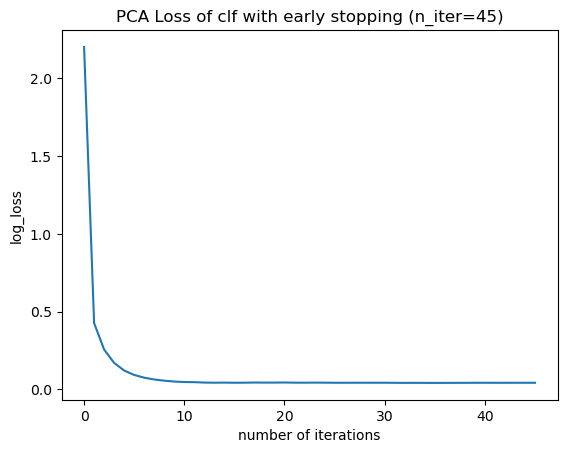

In [15]:
# determining max_iters for PCA 
clf = HistGradientBoostingClassifier(random_state=30, early_stopping=True, learning_rate=0.3)
clf.fit(PCA_train, y_train)

_, ax = plt.subplots()
plt.plot(-clf.validation_score_)
_ = ax.set(
    xlabel="number of iterations",
    ylabel="log_loss",
    title=f"PCA Loss of clf with early stopping (n_iter={clf.n_iter_})",
)
# reach an early stop point at n_iter = 45

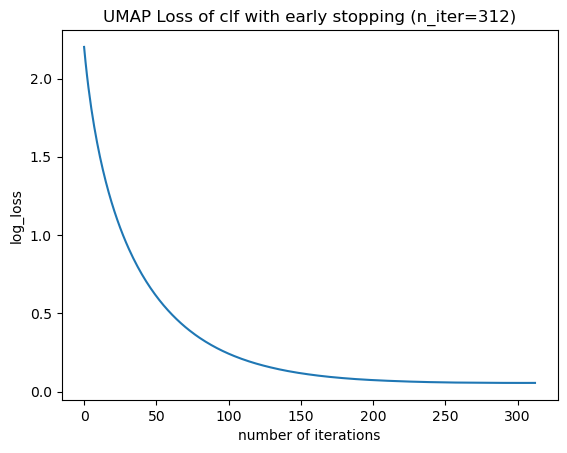

In [ ]:
# determining max_iters for UMAP 
clf = HistGradientBoostingClassifier(random_state=30, early_stopping=True, learning_rate=0.01, max_iter=1000)
clf.fit(UMAP_train, y_train)

_, ax = plt.subplots()
plt.plot(-clf.validation_score_)
_ = ax.set(
    xlabel="number of iterations",
    ylabel="log_loss",
    title=f"UMAP Loss of clf with early stopping (n_iter={clf.n_iter_})",
)
# reach an early stopping point of 312 n_iter

In [17]:
# tune max_depth 
# between 2 and 20
param_grid = {
    'max_depth': np.arange(2, 21, 2) 
}
# test learning_rate for PCA
## set parameters: learning_rate=0.3, n_iter = 45
clf = HistGradientBoostingClassifier(random_state=30, early_stopping=True, learning_rate=0.3, max_iter=45)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print("PCA results:")
print(f"Best max depth: {grid_search.best_params_['max_depth']}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# test learning_rate for UMAP
## set parameters: learning_rate=0.01, max_iter=312
clf = HistGradientBoostingClassifier(random_state=30, early_stopping=True, learning_rate=0.01, max_iter=312)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(UMAP_train, y_train)
print("UMAP results:")
print(f"Best max depth: {grid_search.best_params_['max_depth']}")
print(f"Best cross-validation score: {grid_search.best_score_}")

PCA results:
Best max depth: 4
Best cross-validation score: 0.9912724181961415
UMAP results:
Best max depth: 10
Best cross-validation score: 0.992084771003966


##### Step Two: Testing Models on Unseen Data

In [18]:
# best models after testing parameters
pca_model = HistGradientBoostingClassifier(random_state=30, early_stopping=True, learning_rate=0.3, max_iter=45, max_depth=4)
umap_model = HistGradientBoostingClassifier(random_state=30, early_stopping=True, learning_rate=0.01, max_iter=312, max_depth=10)

# fit models 
pca_model.fit(PCA_train, y_train)
umap_model.fit(UMAP_train, y_train)

# evaluate models on unseen data
pca_predicts = pca_model.predict(PCA_test)

umap_predicts = umap_model.predict(UMAP_test)

# Print additional metrics for PCA model
print("PCA model evaluation:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, pca_predicts):.4f}")
print(f"Precision: {precision_score(y_test, pca_predicts, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, pca_predicts, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, pca_predicts, average='weighted'):.4f}")

# Print additional metrics for UMAP model
print("UMAP model evaluation:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, umap_predicts):.4f}")
print(f"Precision: {precision_score(y_test, umap_predicts, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, umap_predicts, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, umap_predicts, average='weighted'):.4f}")


PCA model evaluation:
Balanced Accuracy: 0.9925
Precision: 0.9928
Recall: 0.9927
F1 Score: 0.9927
UMAP model evaluation:
Balanced Accuracy: 0.9917
Precision: 0.9925
Recall: 0.9923
F1 Score: 0.9924


In [19]:
# Classification Report - any tissues the models are struggling with? 
print("PCA model classification report:")
pca_report = classification_report(y_test, pca_predicts, target_names=le.classes_)
print(pca_report)
print("UMAP model classification report:")
umap_report = classification_report(y_test, umap_predicts, target_names=le.classes_)
print(umap_report)

PCA model classification report:
                precision    recall  f1-score   support

Adipose Tissue       0.97      0.99      0.98       255
         Blood       1.00      1.00      1.00       188
  Blood Vessel       0.98      0.98      0.98       274
         Brain       1.00      1.00      1.00       510
         Colon       1.00      0.98      0.99       145
     Esophagus       1.00      0.98      0.99       295
         Heart       0.99      0.99      0.99       178
          Lung       0.99      1.00      1.00       118
        Muscle       1.00      1.00      1.00       142
          Skin       1.00      1.00      1.00       372

      accuracy                           0.99      2477
     macro avg       0.99      0.99      0.99      2477
  weighted avg       0.99      0.99      0.99      2477

UMAP model classification report:
                precision    recall  f1-score   support

Adipose Tissue       0.96      0.99      0.97       255
         Blood       1.00      1.

Balanced accuracies are a little lower for both models. UMAP continues to outperform PCA model. Good generalized performance on dataset it hasn't seen. 

Both models struggled more with adipose tissue that the other classes. 

#### Strong Learners: Bagging with Random Forest meta-estimators

##### Step One: Parameter Tuning

In [20]:
# result of no parameter tuning: 
clf = RandomForestClassifier(random_state=30)
cv_score = cross_val_score(clf, PCA_train, y_train, cv=cv, scoring='balanced_accuracy')
print(cv_score.mean())
cv2_score = cross_val_score(clf, UMAP_train, y_train, cv=cv, scoring='balanced_accuracy')
print(cv2_score.mean())

0.9916578407544117
0.992569351280373


Base RandomForestClassifer performs better than the GradientBoosting algorithm.

In [21]:
# adjusting n_estimators and max_features
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features}

In [23]:
clf = RandomForestClassifier(random_state=30)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print(f"Best estimators for PCA: {grid_search.best_params_['n_estimators']}")
print(f"Best max features for PCA: {grid_search.best_params_['max_features']}")
print(f"Best cross-validation score for PCA: {grid_search.best_score_}")

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(UMAP_train, y_train)
print(f"Best estimators for UMAP: {grid_search.best_params_['n_estimators']}")
print(f"Best max features for UMAP: {grid_search.best_params_['max_features']}")
print(f"Best cross-validation score for UMAP: {grid_search.best_score_}")

Best estimators for PCA: 200
Best max features for PCA: sqrt
Best cross-validation score for PCA: 0.9917644571460917
Best estimators for UMAP: 600
Best max features for UMAP: log2
Best cross-validation score for UMAP: 0.9926630026240245


In [24]:
# adjusting max_depth 
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node

# Create the param grid
param_grid = {'max_depth': max_depth}

In [25]:
clf = RandomForestClassifier(random_state=30, n_estimators=200, max_features="sqrt")
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print(f"Best max depth for PCA: {grid_search.best_params_['max_depth']}")
print(f"Best cross-validation score for PCA: {grid_search.best_score_}")

clf = RandomForestClassifier(random_state=30, n_estimators=600, max_features="log2")
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(UMAP_train, y_train)
print(f"Best max depth for UMAP: {grid_search.best_params_['max_depth']}")
print(f"Best cross-validation score for UMAP: {grid_search.best_score_}")

Best max depth for PCA: 20
Best cross-validation score for PCA: 0.9918521764443373
Best max depth for UMAP: 20
Best cross-validation score for UMAP: 0.9926630026240245


In [26]:
# adjusting min_samples_split and min_samples_leaf
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64]
param_grid = {'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

In [27]:
clf = RandomForestClassifier(random_state=30, n_estimators=200, max_features="sqrt", max_depth=20)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print(f"Best min samples split for PCA: {grid_search.best_params_['min_samples_split']}")
print(f"Best min samples leaf for PCA: {grid_search.best_params_['min_samples_leaf']}")
print(f"Best cross-validation score for PCA: {grid_search.best_score_}")

clf = RandomForestClassifier(random_state=30, n_estimators=600, max_features="log2", max_depth=20)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
grid_search.fit(UMAP_train, y_train)
print(f"Best min samples split for UMAP: {grid_search.best_params_['min_samples_split']}")
print(f"Best min samples leaf for UMAP: {grid_search.best_params_['min_samples_leaf']}")
print(f"Best cross-validation score for UMAP: {grid_search.best_score_}")

Best min samples split for PCA: 2
Best min samples leaf for PCA: 1
Best cross-validation score for PCA: 0.9918521764443373
Best min samples split for UMAP: 2
Best min samples leaf for UMAP: 1
Best cross-validation score for UMAP: 0.9926630026240245


### Testing on Unseen Data

In [28]:
# best models after testing parameters
pca_model = RandomForestClassifier(random_state=30, n_estimators=200, max_features="sqrt", max_depth=20, min_samples_split=2, min_samples_leaf=1)
umap_model = RandomForestClassifier(random_state=30, n_estimators=600, max_features="log2", max_depth=20, min_samples_split=2, min_samples_leaf=1)

# fit models 
pca_model.fit(PCA_train, y_train)
umap_model.fit(UMAP_train, y_train)

# evaluate models on unseen data
pca_predicts = pca_model.predict(PCA_test)

umap_predicts = umap_model.predict(UMAP_test)

# Print additional metrics for PCA model
print("PCA model evaluation:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, pca_predicts):.4f}")
print(f"Precision: {precision_score(y_test, pca_predicts, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, pca_predicts, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, pca_predicts, average='weighted'):.4f}")

# Print additional metrics for UMAP model
print("UMAP model evaluation:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, umap_predicts):.4f}")
print(f"Precision: {precision_score(y_test, umap_predicts, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, umap_predicts, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, umap_predicts, average='weighted'):.4f}")

PCA model evaluation:
Balanced Accuracy: 0.9927
Precision: 0.9928
Recall: 0.9927
F1 Score: 0.9927
UMAP model evaluation:
Balanced Accuracy: 0.9921
Precision: 0.9929
Recall: 0.9927
F1 Score: 0.9928


In [29]:
# Classification Report - any tissues the models are struggling with? 
print("PCA model classification report:")
pca_report = classification_report(y_test, pca_predicts, target_names=le.classes_)
print(pca_report)
print("UMAP model classification report:")
umap_report = classification_report(y_test, umap_predicts, target_names=le.classes_)
print(umap_report)

PCA model classification report:
                precision    recall  f1-score   support

Adipose Tissue       0.97      0.99      0.98       255
         Blood       1.00      1.00      1.00       188
  Blood Vessel       0.97      0.98      0.98       274
         Brain       1.00      1.00      1.00       510
         Colon       1.00      0.98      0.99       145
     Esophagus       1.00      0.98      0.99       295
         Heart       0.99      1.00      1.00       178
          Lung       1.00      1.00      1.00       118
        Muscle       1.00      1.00      1.00       142
          Skin       1.00      1.00      1.00       372

      accuracy                           0.99      2477
     macro avg       0.99      0.99      0.99      2477
  weighted avg       0.99      0.99      0.99      2477

UMAP model classification report:
                precision    recall  f1-score   support

Adipose Tissue       0.96      1.00      0.98       255
         Blood       1.00      1.